YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0110
Epoch 2/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0011
Epoch 3/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0011
Epoch 4/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0012
Epoch 5/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0011
Epoch 6/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0011
Epoch 7/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0011
Epoch 8/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 9.5826e-04
Epoch 9/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 9.6434e-04
Epoch 10/10
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 8.9358e-04
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted Forex Reserve for Next Day: 1.0679254531860352


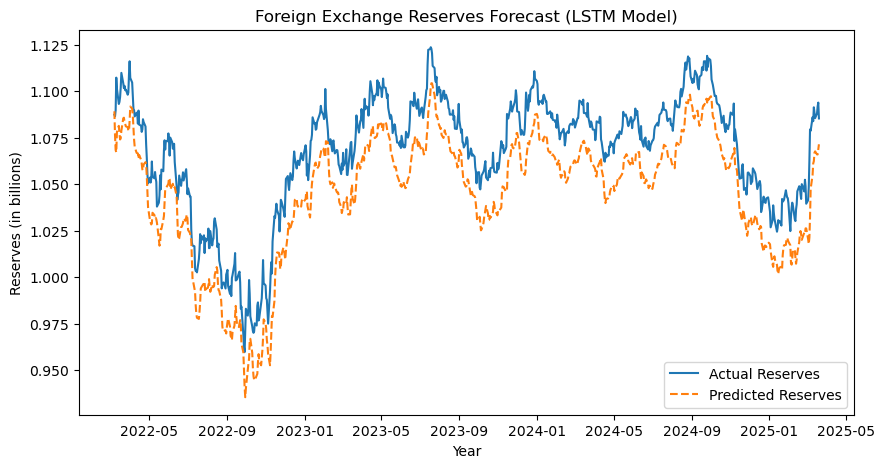

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import datetime

# Fetch live forex data (up to today)
def fetch_forex_data(symbol='EURUSD=X', start='2010-01-01'):
    end = datetime.datetime.today().strftime('%Y-%m-%d')  # Get today's date
    data = yf.download(symbol, start=start, end=end, interval='1d')
    data = data[['Close']].dropna()
    return data

# Load live forex data
df = fetch_forex_data()
df.reset_index(inplace=True)
df.rename(columns={'Date': 'date', 'Close': 'forex_reserves'}, inplace=True)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df['forex_reserves'] = scaler.fit_transform(df[['forex_reserves']])

def prepare_data(series, look_back=3):
    X, Y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back)])
        Y.append(series[i + look_back])
    return np.array(X), np.array(Y)

# Prepare data for LSTM
look_back = 3
X, Y = prepare_data(df['forex_reserves'].values, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
model.fit(X_train, Y_train, batch_size=1, epochs=10)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Predict next day's forex reserve
latest_data = df['forex_reserves'].values[-look_back:]
latest_data = np.reshape(latest_data, (1, look_back, 1))
next_day_prediction = model.predict(latest_data)
next_day_prediction = scaler.inverse_transform(next_day_prediction.reshape(-1, 1))

print(f"Predicted Forex Reserve for Next Day: {next_day_prediction[0][0]}")

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(df['date'][-len(predictions):], scaler.inverse_transform(Y_test.reshape(-1, 1)), label='Actual Reserves')
plt.plot(df['date'][-len(predictions):], predictions, label='Predicted Reserves', linestyle='dashed')
plt.title("Foreign Exchange Reserves Forecast (LSTM Model)")
plt.xlabel("Year")
plt.ylabel("Reserves (in billions)")
plt.legend()
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
mae = mean_absolute_error(Y_test, predictions)


print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 0.8401
MAE: 0.8396


1. this is a lstm model based on tensorflow/keras to predict forex
2. minmax scalar to normalize the model data & to improve lstm training
3. yfinanace - to fetch fores data
4. 80% train , 20% test
5. model test
 a.Root Mean Squared Error (RMSE)
Measures the difference between actual and predicted values. Lower RMSE indicates better accuracy.
 b.Mean Absolute Error (MAE)
Measures the average absolute difference between actual and predicted values
 c.R-squared (R²) Score
Indicates how well the model explains variance in data (1 is best, 0 means no predictive power)

